In [ ]:
import os
import pandas as pd

data_path = os.path.join("data", "chats_20250201_20250320", "bss_chats_20250201_20250320.feather")
data_df = pd.read_feather(data_path)
print(data_df)


               id   chat_id                        created  \
0        99086364  14106513  2025-02-24 16:55:19.386 +0300   
1        99080535  14105206  2025-02-24 15:54:18.497 +0300   
2        99082407  14105206  2025-02-24 16:10:40.936 +0300   
3       100190852  14237685  2025-03-10 12:32:14.665 +0300   
4       100780325  14311502  2025-03-17 15:27:45.434 +0300   
...           ...       ...                            ...   
719433   98037994  13984876  2025-02-12 14:08:23.486 +0300   
719434   98132486  13999359  2025-02-13 16:16:27.357 +0300   
719435   98062681  13988736  2025-02-12 17:48:32.314 +0300   
719436   98010776  13980543  2025-02-12 10:49:29.460 +0300   
719437   98084808  13992349  2025-02-13 10:13:48.772 +0300   

                                                     text  \
0       Вот материал по вашему вопросу. Если это не со...   
1       Без вашего подтверждения мы не смогли передать...   
2       Если у вас остались вопросы, нужны уточнения и...   
3          

In [5]:
id_all = len(data_df["chat_id"].unique())
id_robo = len(data_df["chat_id"][data_df["discriminator"]=="MLRoboChatMessage"])
id_robo, id_all, id_robo/id_all

(27471, 88538, 0.31027355485780117)

In [20]:
# Добавим к чатам длину текста:
data_df["len_w"] = data_df["text"].apply(lambda x: len(x.split()))

# Переведем в дата-время
data_df['created'] = pd.to_datetime(data_df['created'])

# Добавим номер недели
data_df['week_num'] = data_df['created'].dt.isocalendar().week

# Сохраним чаты с роботом:
robo_chats = data_df["chat_id"][data_df["discriminator"]=="MLRoboChatMessage"]
robo_data_df = data_df[data_df["chat_id"].isin(robo_chats)]
robo_data_df.drop('created', axis=1).to_excel(os.path.join("data", "chats_20250201_20250320", "chats_with_bot_answer.xlsx"))

In [50]:
# Выберем чаты, в которых отвечал робот
id_robo_df = data_df[data_df["discriminator"]=="MLRoboChatMessage"]
print(id_robo_df.info())
data_path = os.path.join("data", "chats_20250201_20250320", "bss_user_first_phrase_20250201_20250320_3_and_more.feather")
first_ph_df = pd.read_feather(data_path)

# Добавим к первой фразе номер недели
data_df["chat_id"] = data_df["chat_id"].astype(int)
first_ph_robo_df = pd.merge(id_robo_df[["week_num", "chat_id"]], first_ph_df, on="chat_id", how="left")

first_ph_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27471 entries, 0 to 719427
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype                    
---  ------         --------------  -----                    
 0   id             27471 non-null  int64                    
 1   chat_id        27471 non-null  int64                    
 2   created        27471 non-null  datetime64[ns, UTC+03:00]
 3   text           27471 non-null  object                   
 4   discriminator  27471 non-null  object                   
 5   user_id        27471 non-null  int64                    
 6   evaluation     0 non-null      float64                  
 7   len_w          27471 non-null  int64                    
 8   Week_Number    27471 non-null  UInt32                   
 9   week_num       27471 non-null  UInt32                   
dtypes: UInt32(2), datetime64[ns, UTC+03:00](1), float64(1), int64(4), object(2)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Range

In [51]:
# первая фраза в тех чатах, в которых ответил робот:
id_robo_df["chat_id"] = id_robo_df["chat_id"].astype(int)
first_ph_robo_df = first_ph_df[first_ph_df["chat_id"].isin(id_robo_df["chat_id"])]
first_ph_robo_df

/tmp/ipykernel_131090/820959776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_robo_df["chat_id"] = id_robo_df["chat_id"].astype(int)


,chat_id,FirstPhrase,len_w
6,13848305,Доброе утро!,2
7,13848305,"ИП, регистрация в ДНР, представляет собой сеть...",12
8,13848307,отчет п-4,2
11,13848330,добрый день!,2
12,13848330,"Анна, приветствую Вас!",3
...,...,...,...
96747,14341312,Вопрос о налоге на прибыль. Медицинская органи...,56
96750,14341324,Добрый вечер,2
96751,14341324,может ли ООО подать нулевую декларацию по УСН ...,17
96756,14341347,Здравствуйте!,1


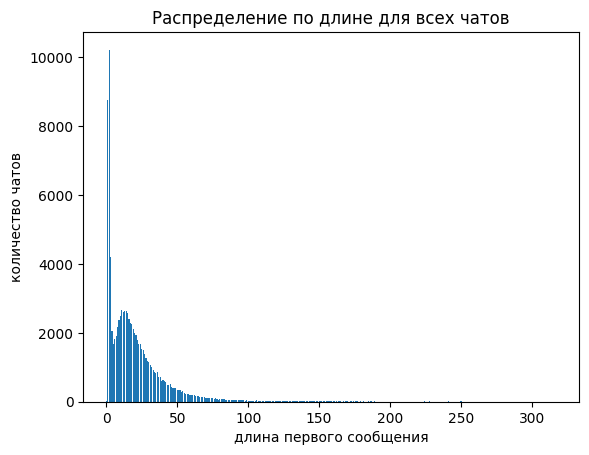

In [52]:
# распределение всех чатов по длине первого сообщения
import matplotlib.pyplot as plt

mss_by_len_fst_ph = first_ph_df[["chat_id", "len_w"]].groupby("len_w", as_index=False).count()

fig, ax = plt.subplots()
ax.bar(mss_by_len_fst_ph["len_w"], mss_by_len_fst_ph["chat_id"])

ax.set_xlabel('длина первого сообщения')
ax.set_ylabel('количество чатов')
ax.set_title('Распределение по длине для всех чатов')

plt.show()

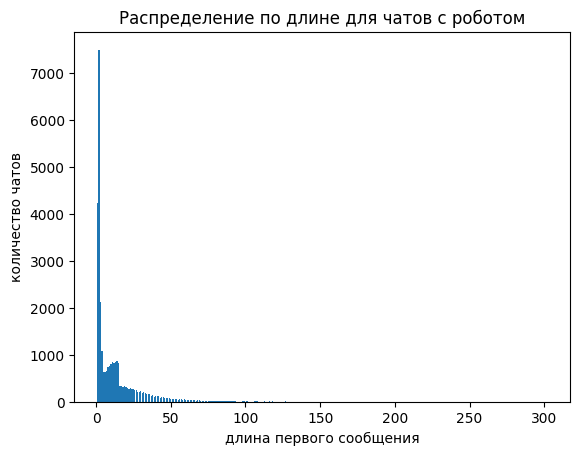

In [53]:
# посмотрим распределение по длине для первых сообщений в чатах, на которые отвечает робот
mss_by_len = first_ph_robo_df[["chat_id", "len_w"]].groupby("len_w", as_index=False).count()
fig, ax = plt.subplots()
ax.bar(mss_by_len["len_w"], mss_by_len["chat_id"])


ax.set_xlabel('длина первого сообщения')
ax.set_ylabel('количество чатов')
ax.set_title('Распределение по длине для чатов с роботом')

plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35564 entries, 0 to 35563
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   week_num     35564 non-null  UInt32
 1   chat_id      35564 non-null  int64 
 2   FirstPhrase  35564 non-null  object
 3   len_w        35564 non-null  int64 
dtypes: UInt32(1), int64(2), object(1)
memory usage: 1007.3+ KB
None
<IntegerArray>
[9, 10, 7, 8, 11, 6, 12, 5]
Length: 8, dtype: UInt32


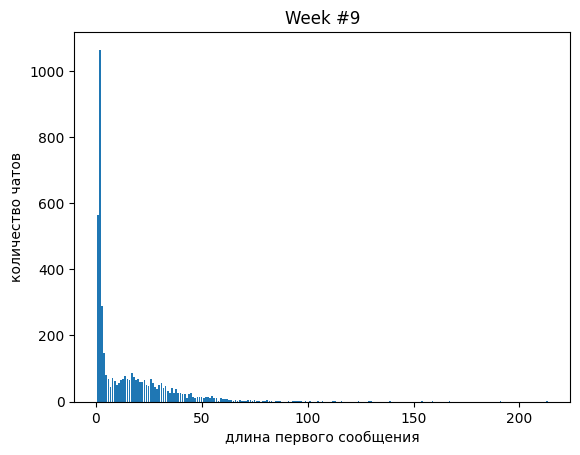

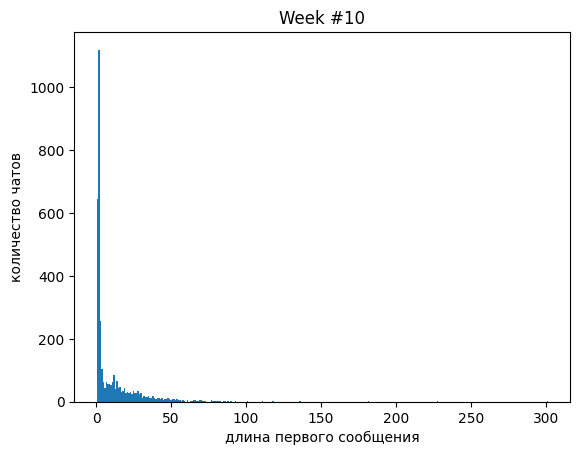

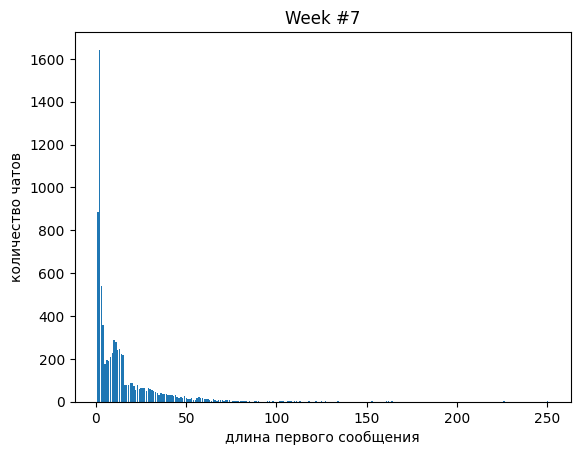

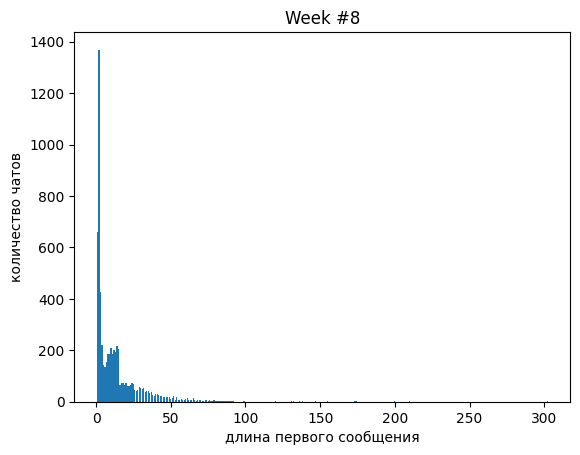

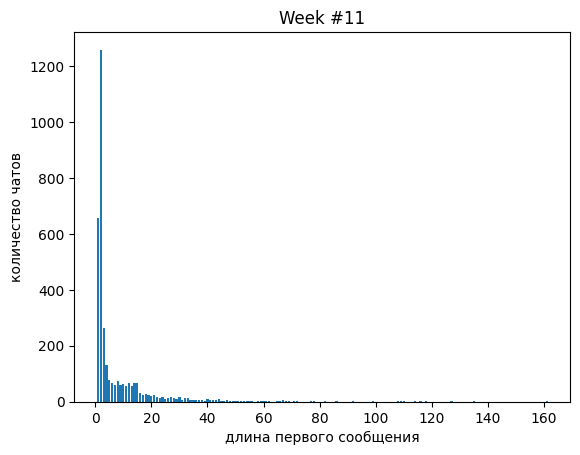

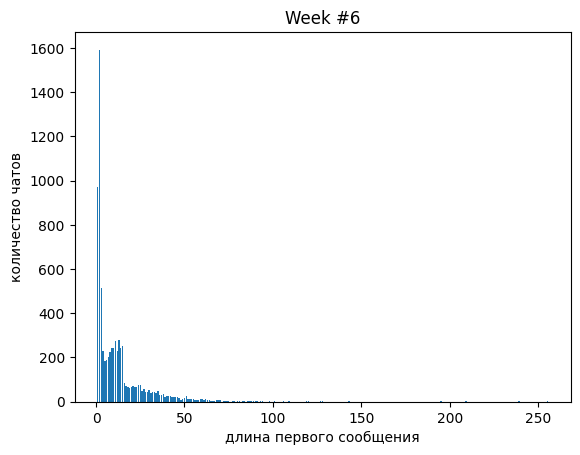

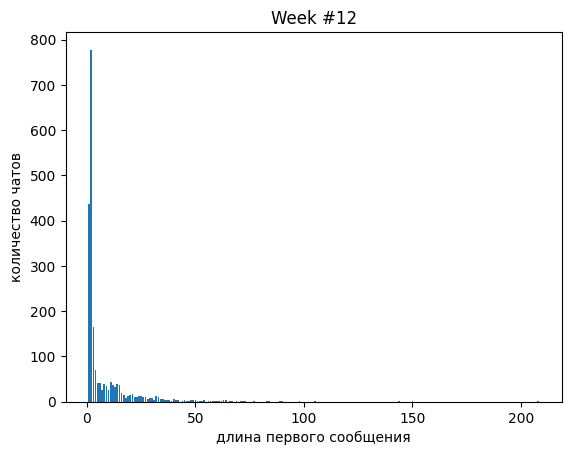

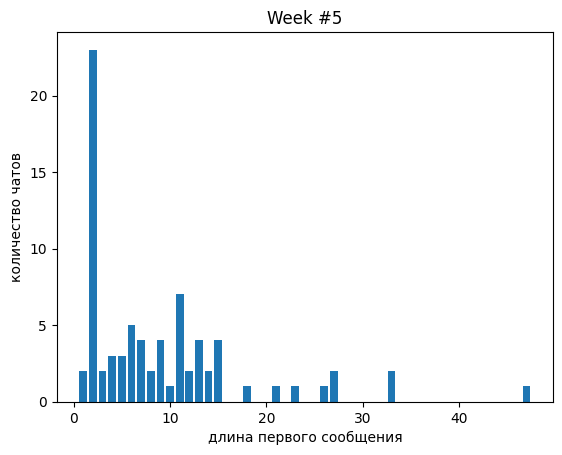

In [49]:
# Построим  распределение по неделям:
print(first_ph_robo_df.info())
print(first_ph_robo_df["week_num"].unique())
first_ph_robo_df.to_excel(os.path.join("data", "chats_20250201_20250320", "chats_with_bot_answer_first_phrase.xlsx"))
# посмотрим распределение по длине для первых сообщений в чатах, на которые отвечает робот
for wn in first_ph_robo_df["week_num"].unique():
    mss_by_len = first_ph_robo_df[first_ph_robo_df["week_num"] == wn][["chat_id", "len_w"]].groupby("len_w", as_index=False).count()
    fig, ax = plt.subplots()
    ax.bar(mss_by_len["len_w"], mss_by_len["chat_id"])


    ax.set_xlabel('длина первого сообщения')
    ax.set_ylabel('количество чатов')
    ax.set_title('Week #' + str(wn))

    plt.show()